In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gc
import copy
import random
import numpy as np
import axelrod as axl
from time import time
from pprint import pprint
from itertools import permutations
from collections import namedtuple, deque

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State

In [4]:
GAME_LEN = 20 + 1
C = axl.Action.C
D = axl.Action.D
GAME = axl.Game(r=3, s=0, t=5, p=1)

def Match(players, turns=GAME_LEN, reset=True):
    return axl.Match(players, turns=turns, reset=reset, game=GAME)

def play(player1, player2, match):
    game = match((player1, player2))
    actions = game.play()
    scores = game.scores()[:-1]
    print(scores)
    print(f"Player 1 score = {sum(list(zip(*scores))[0])}")
    print(f"Player 2 score = {sum(list(zip(*scores))[1])}")
    return game

In [5]:
play(axl.Alternator(), axl.Random(), Match)
game = play(axl.Prober4(), axl.TitForTat(), Match)

[(3, 3), (5, 0), (3, 3), (1, 1), (0, 5), (5, 0), (0, 5), (1, 1), (3, 3), (1, 1), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (1, 1)]
Player 1 score = 43
Player 2 score = 48
[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


In [6]:
s = State(GAME_LEN)
print(s.values())

s.push(C, D)
print(s)

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]
[deque([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1], maxlen=21),
 deque([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0], maxlen=21)]


In [135]:
dqn = DQN([
#                     network.Flatten_layer(),
#                     network.Maxout_layer(GAME_LEN*2, 100),
#                     network.Maxout_layer(100, 40),
#                     network.Maxout_layer(40, 20),
#                     network.Maxout_layer(20, 2),
    
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ])
p1 = NNplayer(dqn, ReplayMemory(2000), State(GAME_LEN), gamma=0.9)
del dqn
gc.collect()

param = {"lr": 1e-5, 'batch': 16, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'decay': 0.0}

In [136]:
# enable test mode
with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_values:

[[-0.948  0.593]]
[[-0.286  0.356]]
[[-1.219  0.12 ]]
[[-0.701  0.442]]
[[-0.221  0.327]]
[[0.285 0.309]]
[[0.618 0.595]]
[[0.64 0.84]]
[[-0.153  0.672]]
[[0.143 0.478]]
[[-0.218  0.599]]
[[0.454 0.149]]
[[0.206 0.435]]
[[ 0.157 -0.167]]
[[0.406 0.463]]
[[ 0.107 -0.034]]
[[0.709 0.546]]
[[ 0.561 -0.326]]
[[ 0.349 -0.487]]
[[0.727 0.156]]
[[ 1.708 -0.294]]


In [137]:
# initial experience
# high greedy -> more random exploration
p1.greedy = 0.5
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
    players = (p1, axl.Alternator())
    game = Match(players)
    game.play()
p1.greedy = 0.2

In [138]:
for _ in range(20):
    start = time()
    p1.train(60, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    [Match((p1, axl.Alternator())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
# left: loss for cooperation
# right: loss for defection

loss: [0.767 0.937],            time: +21.21 sec
loss: [0.675 0.709],            time: +23.82 sec
loss: [0.52  0.748],            time: +25.93 sec
loss: [0.424 0.61 ],            time: +24.19 sec
loss: [0.446 0.615],            time: +22.05 sec
loss: [0.251 0.453],            time: +21.76 sec
loss: [0.307 0.332],            time: +20.27 sec
loss: [0.313 0.43 ],            time: +25.13 sec
loss: [0.324 0.348],            time: +32.55 sec
loss: [0.365 0.294],            time: +21.24 sec
loss: [0.321 0.27 ],            time: +23.25 sec
loss: [0.321 0.387],            time: +21.15 sec
loss: [0.402 0.352],            time: +19.79 sec
loss: [0.341 0.362],            time: +19.91 sec
loss: [0.28  0.457],            time: +18.30 sec
loss: [0.258 0.339],            time: +19.29 sec
loss: [0.235 0.259],            time: +19.72 sec
loss: [0.233 0.317],            time: +19.21 sec
loss: [0.206 0.289],            time: +21.12 sec
loss: [0.248 0.399],            time: +22.08 sec


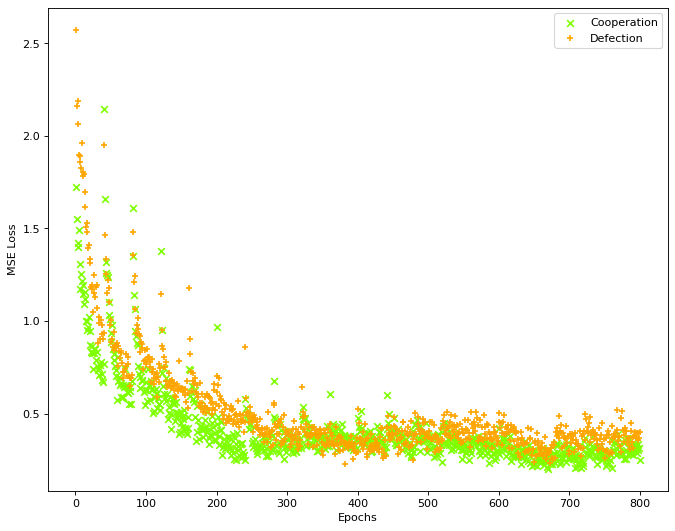

In [139]:
p1.plot()

In [90]:
with p1:
    play(p1, axl.TitForTat(), Match)

[[21.    21.773]]
[[19.068 18.405]]
[[21.088 22.93 ]]
[[18.243 20.158]]
[[20.065 22.231]]
[[18.925 18.039]]
[[20.972 21.3  ]]
[[18.836 18.577]]
[[20.985 20.929]]
[[18.597 18.596]]
[[18.869 18.779]]
[[18.184 16.995]]
[[17.498 16.494]]
[[16.48  15.439]]
[[15.297 13.593]]
[[14.176 12.158]]
[[12.693 12.135]]
[[11.219  9.098]]
[[7.297 5.733]]
[[3.437 4.822]]
[[-0.116 -0.58 ]]
[(5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 55
Player 2 score = 50


In [77]:
with p1:
    play(p1, axl.Alternator(), Match)

[[22.74 23.02]]
[[20.55 21.13]]
[[21.83 24.69]]
[[20.84 22.59]]
[[23.04 24.98]]
[[20.73 22.54]]
[[21.77 24.23]]
[[20.   21.45]]
[[20.8  22.51]]
[[18.52 19.39]]
[[18.46 20.41]]
[[16.02 17.14]]
[[15.74 17.97]]
[[13.47 14.23]]
[[12.3  14.59]]
[[ 9.7  10.72]]
[[ 8.54 10.7 ]]
[[5.34 6.39]]
[[3.69 5.95]]
[[0.29 1.04]]
[[ 0.03 -0.13]]
[(5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1)]
Player 1 score = 60
Player 2 score = 10


In [123]:
play(axl.TitForTat(), axl.Alternator(), Match)

play(axl.TitForTat(), axl.TitForTat(), Match)

[(3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5)]
Player 1 score = 48
Player 2 score = 53


In [46]:
# theoritical Q values
# assuming both player cooperate to the end
for i in range(20):
    print(f'{3.0+3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)):.2f}')

26.35
25.95
25.50
25.00
24.44
23.82
23.14
22.37
21.53
20.59
19.54
18.38
17.09
15.65
14.06
12.29
10.32
8.13
5.70
3.00


In [28]:
p1.network.policy_net.print_parameters()

--0--
Printing flatten layer:
{'shape': (1, 2, 21), 'type': 'flatten'}
--1--
Printing linear layer:
{'bias': 0.01,
 'input': array([[-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  0.,  1.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  0.,  1.]]),
 'input_nodes': 42,
 'm1': array([[ 0.01, -0.01,  0.  , ..., -0.  ,  0.  ,  0.01],
       [ 0.01, -0.01,  0.  , ..., -0.  ,  0.  ,  0.01],
       [ 0.01, -0.01,  0.01, ..., -0.  ,  0.  ,  0.01],
       ...,
       [-0.01,  0.01, -0.  , ...,  0.  , -0.  ,  0.  ],
       [-0.01,  0.01,  0.  , ..., -0.  ,  0.  ,  0.  ],
       [-0.01,  0.01, -0.  , ...,  0.  , -0.  , -0.01]]),
 'm2': array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ...